# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

Загрузим в датафрейм имена файлов с изображениями и значения возрастов (целевой признак)

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [3]:
labels.info()
print()
display(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В выборке 7591 фото. Посмотрим на график распределения возраста.

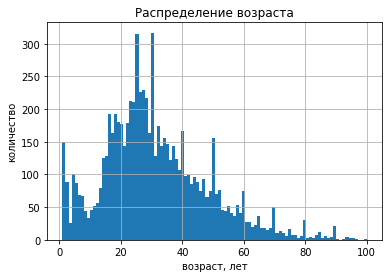

In [4]:
ax = labels.real_age.hist(bins=100)
ax.set_title('Распределение возраста')
ax.set_xlabel('возраст, лет')
ax.set_ylabel('количество')
plt.show()

Распределение скошено влево. Наибольшее количество фото в возрасте примерно 17-40 лет. В выборке есть провалы на участке до 15 лет, и  мало объектов после 50 лет. Точность в этих диапазонах будет ниже.

Посмотрим на фото в выборке, для этого создадим загрузчик. Для наглядности подпишем под фото реальный возраст.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
                                        dataframe=labels,
                                        directory='/datasets/faces/final_files/',
                                        x_col='file_name',
                                        y_col='real_age',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='raw',
                                        seed=12345) 

Found 7591 validated image filenames.


In [6]:
features, target = next(train_gen_flow)
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


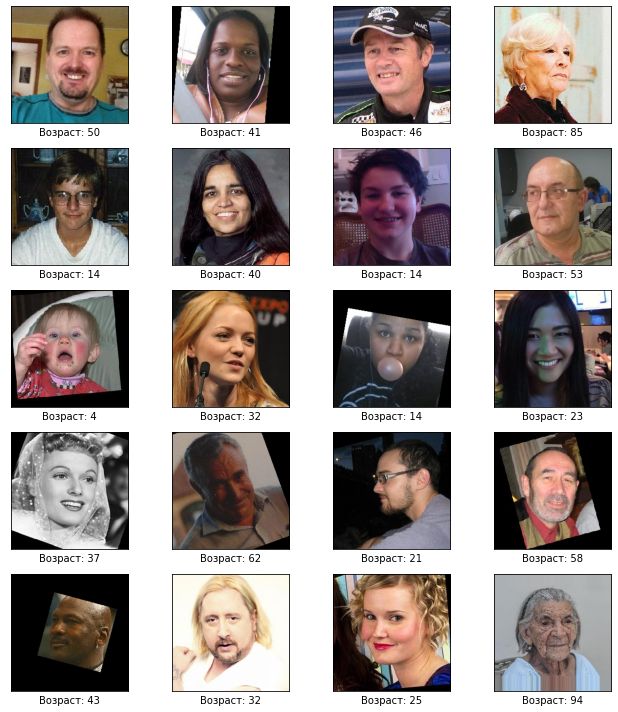

In [7]:
# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel('Возраст: ' + str(target[i]))

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фото разного качества, цветные и черно-белые, разные ракурсы, с обрезанными полями, есть в профиль, в очках и с постороннми предметами в кадре и др. В общем все как в жизни. Определить возраст видимо будет не просто и выборка не очень большая. Можно дополнительно попробовать применить аугментацию.

## Обучение модели

Код обучения модели для запуска в GPU-тренажёре.

```python

import pandas as pd
rom tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 horizontal_flip=True,
                                 rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='training',
                                                    seed=12345
                                                    )

    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345
                                                    )

    return test_datagen_flow


def create_model(input_shape):

    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(
                        input_shape=input_shape,
                        weights='imagenet',
                        include_top=False
                       )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результаты обучения и тестирования модели:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-03-30 20:03:35.161164: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-30 20:03:39.072899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 128s - loss: 205.1161 - mae: 10.3949 - val_loss: 907.6956 - val_mae: 25.2987
Epoch 2/20
356/356 - 38s - loss: 81.4158 - mae: 6.8690 - val_loss: 173.0579 - val_mae: 9.8942
Epoch 3/20
356/356 - 38s - loss: 59.4794 - mae: 5.8949 - val_loss: 83.9918 - val_mae: 6.9287
Epoch 4/20
356/356 - 38s - loss: 43.3967 - mae: 5.0169 - val_loss: 77.5022 - val_mae: 6.5038
Epoch 5/20
356/356 - 38s - loss: 35.1113 - mae: 4.5476 - val_loss: 84.7325 - val_mae: 7.2227
Epoch 6/20
356/356 - 38s - loss: 26.9925 - mae: 3.9979 - val_loss: 73.1024 - val_mae: 6.2517
Epoch 7/20
356/356 - 38s - loss: 20.1411 - mae: 3.4628 - val_loss: 73.5108 - val_mae: 6.3502
Epoch 8/20
356/356 - 38s - loss: 16.1137 - mae: 3.0158 - val_loss: 70.3402 - val_mae: 6.3297
Epoch 9/20
356/356 - 38s - loss: 14.4498 - mae: 2.8513 - val_loss: 73.0100 - val_mae: 6.3578
Epoch 10/20
356/356 - 38s - loss: 13.2234 - mae: 2.7734 - val_loss: 62.9548 - val_mae: 5.8265
Epoch 11/20
356/356 - 39s - loss: 12.2166 - mae: 2.6458 - val_loss: 73.2919 - val_mae: 6.2412
Epoch 12/20
356/356 - 38s - loss: 11.7025 - mae: 2.6184 - val_loss: 74.4507 - val_mae: 6.2698
Epoch 13/20
356/356 - 38s - loss: 10.9641 - mae: 2.5275 - val_loss: 66.5076 - val_mae: 6.1686
Epoch 14/20
356/356 - 38s - loss: 10.9956 - mae: 2.5327 - val_loss: 95.6514 - val_mae: 7.5413
Epoch 15/20
356/356 - 38s - loss: 11.2193 - mae: 2.5414 - val_loss: 61.1707 - val_mae: 5.8527
Epoch 16/20
356/356 - 38s - loss: 10.1236 - mae: 2.4187 - val_loss: 61.9090 - val_mae: 5.8395
Epoch 17/20
356/356 - 38s - loss: 9.4935 - mae: 2.3356 - val_loss: 63.2834 - val_mae: 5.8633
Epoch 18/20
356/356 - 39s - loss: 9.6589 - mae: 2.3774 - val_loss: 60.8588 - val_mae: 5.7951
Epoch 19/20
356/356 - 39s - loss: 9.9166 - mae: 2.3916 - val_loss: 63.3952 - val_mae: 5.8823
Epoch 20/20
356/356 - 39s - loss: 8.7876 - mae: 2.2620 - val_loss: 61.7787 - val_mae: 5.8255

119/119 - 9s - loss: 61.7787 - mae: 5.8255
Test MAE: 5.8255

```

## Анализ обученной модели

Финальная модель нейронной сети построена на мощном и эффективном алгоритме ResNet50. Итоговая метрика MAE на тестовой выборке достигла уровня 5.8255. Для обучения было использовано 20 эпох, скорость обучения (learning rate) выбрана 0.0001, кроме того для ImageDataGenerator обучающей выборки было применено отражение по гризонтали, что дало дополнительный прирост точности. 

Возможно, дальнейшее обучение еще улучшит метрику, но и повышается вероятность переобучения. На 20 эпохах на обучающей ваыборке МАЕ уже составляет 2.262. При необходимости, для улучшения качества модели также еще можно поработать с входными данными - если возможно увеличить выборку фото ( в т.ч. за счет аугментации), поработать с балансом распределения возрастов. 

Но и полученная итоговая точность является более чем достаточной, целевая метрика по условиям задания была установлена на уровне не более 8, что было достигнуто уже на 3 эпохе. 